In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 15})
sns.set_style('whitegrid')
%matplotlib notebook

In [4]:
# pretty print all cell's output and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [4]:
pyspark.version.__version__

'3.0.1'

- Removing non-null constraints creates ER problem in account_events, i.e. which policy does a ticket correspond to?  
- Can try and merge event histories after the fact with a regular job that runs after account_event_history creation  
     - Pandas job
     - Spark job. Can run in standalone mode and have cron run pyspark job, need to deal with environment issues.  Docker could be useful, need to deal with local VPN issue and syncing notebooks outside containers (bind volumes?). Or try AWS Glue, whichever is better for testing locally then remotely quickly.
     - ER method becomes important, current may double count be just aligning timestamps, maybe a bit better to pull policy start/expiration dates  
     - SQL job on tickets table before account events is another method
- Moving to a graph seems better to avoid schema changes in the future and may help with increased integration, adding relationships becomes easier. This also allows for probabilistic ER using multiple inference sources rather single sources before merging into account events.

## Spark 

In [5]:
conf = SparkConf()
#https://search.maven.org/artifact/org.postgresql/postgresql/42.2.18.jre7/jar
conf.set("spark.jars.packages", "org.postgresql:postgresql:42.2.18.jre7") 
# conf.set("spark.driver.bindAddress","localhost")
conf.getAll()

dict_items([('spark.jars.packages', 'org.postgresql:postgresql:42.2.18.jre7')])

In [6]:
spark = SparkSession \
    .builder \
    .appName("account events ER") \
    .config(conf=conf) \
    .getOrCreate()

In [12]:
spark.stop()

### Get data from dw

In [7]:
import getpass
import pgpasslib
import os

In [8]:
# SQLAlchemy connection to DW
USER = os.environ["PGUSER"]    # "asoto"
HOST =  os.environ["PGHOST"]   # "attune-dw.cy4eanlelmyk.us-east-2.rds.amazonaws.com"
DB = os.environ["PGDATABASE"]  # "attune_dw"

JDBC_URL_NOPASS = f"jdbc:postgresql://{HOST}/{DB}?user={USER}"
JDBC_URL = JDBC_URL_NOPASS + f"&password={pgpasslib.getpass(host=HOST, dbname=DB, user=USER)}" 

[connectivity issues with VPN](https://databricks.gitbooks.io/databricks-spark-knowledge-base/content/troubleshooting/connectivity_issues.html)  
[stack overflow](https://stackoverflow.com/questions/34601554/mac-spark-shell-error-initializing-sparkcontext)

In [9]:
df = spark.read.jdbc(url=JDBC_URL,
                     table="(select count(*) from account_events) a",
                     properties={'driver': "org.postgresql.Driver"})

In [10]:
df.show()

KeyboardInterrupt: 

Script template

In [ ]:
"""SimpleApp.py"""
# from pyspark.sql import SparkSession

# logFile = "YOUR_SPARK_HOME/README.md"  # Should be some file on your system
# spark = SparkSession.builder.appName("SimpleApp").getOrCreate()
# logData = spark.read.text(logFile).cache()

# numAs = logData.filter(logData.value.contains('a')).count()
# numBs = logData.filter(logData.value.contains('b')).count()

# print("Lines with a: %i, lines with b: %i" % (numAs, numBs))

# spark.stop()

### read file

Gives same error with VPN

In [12]:
df = spark.read.csv('../data/test_er.csv', 
                    header=True)
#this works with VPN off!

In [13]:
df.show()

+--------------+--------------------+--------------------+--------------------+
|account_number|       policy_number|       event_history|            event_ts|
+--------------+--------------------+--------------------+--------------------+
|    0000000000|                null|                 qqq|{2020-05-28 14:16...|
|    0000256453|ORCHIA00001HIBP-2...|                  ga|{2019-10-14 14:56...|
|    0000256453|ORCHIA00001HIBP-2...|              fhklia|{2020-09-14 16:50...|
|    0000256453|                null|         qqrrrrrrrrr|{2019-10-10 17:25...|
|    0000316716|AJGALL0001HIBP-39...|               geaee|{2020-03-04 18:22...|
|    0000316716|AJGALL0001HIBP-39...|                 fhi|{2021-02-02 00:14...|
|    0000316716|                null|             rrrrrrr|{2021-02-02 07:31...|
|    0000521037|MORSTAN00001HIBP-...|                gaaa|{2019-07-25 20:42...|
|    0000521037|MORSTAN00001HIBP-...|       faahjiahjklip|{2020-06-25 13:54...|
|    0000521037|                null|qqr

## pandas

### read from db

In [245]:
from attU import sql

In [248]:
query = f"""
    select
    *
    from personal.src_aeh limit 100;
    """

dw_con = sql.attune_dw_engine
df = pd.read_sql_query(query, con=dw_con)

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [261]:
df.head()

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


account_number              policy_number event_history  \
0     0000000000                       None           qqq   
1     0000211474  MORSTAN00001HIBP-17728-01            ga   
2     0000211474  MORSTAN00001HIBP-17728-02        fhklia   
3     0000256453   ORCHIA00001HIBP-28035-01            ga   
4     0000256453   ORCHIA00001HIBP-28035-02        fhklia   

                                            event_ts  
0  [2020-05-28 14:16:15, 2020-08-04 18:43:19, 202...  
1  [2019-06-05 16:08:06.971000, 2019-06-14 00:00:00]  
2  [2020-05-08 12:48:44.690000, 2020-05-08 15:30:...  
3  [2019-10-14 14:56:23.437000, 2019-10-20 00:00:00]  
4  [2020-09-14 16:50:11.255000, 2020-09-14 19:30:...

In [263]:
test = [4,5]
ind = 5

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [291]:
[5]

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


list

In [288]:
isinstance(np.array([5]).squeeze().tolist(), int)

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

### Read from csv

In [1]:
from typing import List, Union
import datetime
def array_string_2_list(
        pg_array_string: str,
        arr_enclosure='{}',
        sep=',',
        parse_func=None,
        parse_dates=False,
        datetime_format: str = '%Y-%m-%d %H:%M:%S.%f') -> List[Union[datetime.datetime, str]]:
    
    '''
    Convert string representation of iterable into a list. User can specify array 
    enclosure chars to strip from string and element seperator during parsing (default 
    curly braces for postgres array), a method to further parse the string elements after 
    splitting to a list, and whether/how to parse array items to datetime objects. Note if both 
    parse_func and parse_dates are specified/True, datetime conversion will take place after
    string parsing.
    '''
    
    out_list = pg_array_string.strip(arr_enclosure).split(sep)
    if parse_func:
        out_list = [parse_func(i) for i in out_list]
    if parse_dates:
        return [datetime.datetime.strptime(i, datetime_format) for i in out_list]
    return out_list

In [5]:
df = pd.read_csv('../data/test_er.csv', 
                 converters={'event_ts': lambda x: array_string_2_list(x, parse_dates=True)})

In [6]:
df.replace({np.nan:None}, inplace=True)

In [294]:
df.head().account_number.iloc[0]

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'0000000000'

In [260]:
missing_policy_nums_df.account_number.unique().size

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


36

In [236]:
# ---Account numbers without policies
# find all relevant account numbers
missing_policy_nums_df = df[(~df.account_number.isnull())
                            & (df.policy_number.isnull())]

# for all account numbers with NULL policies, try to resolve
# only rows
new_df_list = []
for a_num in missing_policy_nums_df.account_number.values:
    rows = resolve_nulls(df, a_num)
    new_df_list.append(rows)

# concat new and old rows
new_df = pd.concat(new_df_list)
resolved_df = pd.concat(
    [df.dropna(subset=['account_number', 'policy_number']), new_df])

# resolved_df now has newly resolved and old policy num errows
# need to therefore merge rows with multiple policy numbers
# pnum_filt = resolved_df.policy_number.value_counts() > 1

# merge resolved and old rows
merged_df = merge_rows(resolved_df)
final_df = pd.concat(
    [resolved_df[resolved_df.policy_number.isnull()], merged_df])

# Policies without account numbers

In [239]:
check = df.merge(final_df, on=['account_number', 'policy_number'])

In [244]:
check[check.event_history_y == check.event_history_x]

account_number               policy_number  \
0                0                        None   
1           256453    ORCHIA00001HIBP-28035-01   
4           316716     AJGALL0001HIBP-39862-01   
7           521037   MORSTAN00001HIBP-21604-01   
10          659842    CMFRST00001HIBP-36232-01   
13          754369     PHGRP00001HIBP-46324-01   
14          754369                        None   
17         1132804   MORSTAN00001HIBP-27399-01   
21         1420143     RPSSI00001HIBP-21229-01   
22         1420143     RPSSI00001HIBP-21229-02   
23         1420143                        None   
24         1442702                        None   
28         1552624   SIACANT00001HIBP-25465-01   
29         1552624                        None   
30         1566409    EMSTBR00001HIBP-34365-01   
32         2155010                        None   
35         2258191    CMFRST00001HIBP-21177-01   
36         2258191    CMFRST00001HIBP-21177-02   
37         2258191                        None   
38         2385043                        None   
39         2402792                        None   
42         2556542      JOHN00001HIBP-22702-01   
48         3058281    CRVWAR00001HIBP-02407-01   
49         3058281    CRVWAR00001HIBP-02407-02   
50         3058281    CRVWAR00001HIBP-02407-03   
56         4231892                   043745320   
58         4231892     FAIRM00001HIBP-24655-01   
61         4617323   MORSTAN00001HIBP-29371-01   
64         5128230   MORSTAN00001HIBP-27975-01   
66         5149363                   043747375   
68         5149363    EFFCOV00001HIBP-14453-01   
71         5311588  KIMINSAG00001HIBP-30320-01   
73         5366705                   043742853   
74         5366705                   043744134   
76         5366705     AMSUIS0001HIBP-05172-01   
77         5366705     AMSUIS0001HIBP-05172-02   
80         5390680    HULLNO00001HIBP-29653-01   
84         5543755                        None   
85         5676500   RISKMAG00001HIBP-08188-01   
89         5810770     RPSSI00001HIBP-09481-01   

                                      event_history_x  \
0                                                 qqq   
1                                                  ga   
4                                               geaee   
7                                                gaaa   
10                                                 ga   
13                                             gahjic   
14                                                qrr   
17                                                 ga   
21                                              gahji   
22                                            fhklacp   
23                                                  q   
24                                                  q   
28                                          geaaaaaac   
29                                                  q   
30                                         gahjikjlip   
32                                                  q   
35                                                gae   
36                                           fhklapie   
37                                                  q   
38                                                  q   
39                                                  q   
42                                  gaaaaaahjklpiaaaa   
48                                               gcee   
49                                              hfkia   
50                                               fhia   
56                                               aaaa   
58                                              gaaaa   
61                            gahjkiaaaaaaaeaahjkelip   
64                                           gahjklip   
66                                      ahkjliphjklpi   
68                                             gahjki   
71                                              gahji   
73  ahjklipahjiahjklpiahiahjkiahjklipahjiahjklipah...   
74             

In [241]:
for c in df.columns[:2]:
    print(c)
    df[c].nunique()
    final_df[c].nunique()

account_number


36

36

policy_number


64

64

In [203]:
#ER v1
def resolve_nulls(df, a_num):
    #get all rows for account number
    adf = df[df.account_number==a_num]
    #get the first row where policy number is nul
    adf_null = adf[adf.policy_number.isnull()].iloc[0]
    #iterate through non-null policy rows, finding where NULL policy
    #events fit by ts
    matched_inds = []
    new_records = []
    for row in adf[~adf.policy_number.isnull()].itertuples():
        p_num = row.policy_number
        p_start = row.event_ts[0]
        p_end = row.event_ts[-1]
        # find ticket ts inds that fall within policy event bounds
        start_check = np.array([d.total_seconds()
                                for d in (p_start - np.array(adf_null['event_ts']))])
        end_check = np.array([d.total_seconds()
                              for d in (p_end - np.array(adf_null['event_ts']))])
        inds = np.argwhere((start_check <= 0) & (end_check >= 0)).squeeze().tolist()
        if inds:
            # track indices matched with current policy
            matched_inds.extend(inds)
            # create new record of ticket events with matched policy number
            history = ''.join([adf_null['event_history'][i] for i in inds])
            ts = [adf_null['event_ts'][i] for i in inds]
            new_records.append((a_num, p_num, history, ts))
    
    #create a new NULL-policy record for unmatched events
    remaining_inds = [i for i in range(
        len(adf_null['event_history'])) if i not in matched_inds]
    if remaining_inds:
        history = ''.join([adf_null['event_history'][i] for i in remaining_inds])
        ts = [adf_null['event_ts'][i] for i in remaining_inds]
        new_records.append((a_num, None, history, ts))
    
    return pd.DataFrame(new_records, columns=df.columns)

def merge_histories(grp):
    '''
    Merge event_history and event_ts columns from multiple rows by sorting
    timestamps in the event_ts lists.

    Returns
        pandas Series of (event_history, event_ts)
    '''
    # makes tuples of (event, ts)
    zipped = grp.apply(lambda x: list(
        zip(x['event_history'], x['event_ts'])), axis=1)
    # sorts tuples by timestamp
    sort_date = sorted(np.vstack(zipped), key=lambda x: x[1])
    return pd.Series((''.join(
        [event for event, ts in sort_date]),
        [ts for event, ts in sort_date]
    ))


def merge_rows(df):
    '''
    Apply merge_histories() to grouped rows.

    Returns
        pandas DataFrame
    '''
    return df.groupby(['account_number', 'policy_number']).\
        apply(lambda x: merge_histories(x)).\
        reset_index().\
        rename(columns={0: 'event_history', 1: "event_ts"})

In [334]:
pd.to_datetime("2020-01-01").__str__()

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'2020-01-01 00:00:00'

In [211]:
df[df.account_number.isin(adiff)]

account_number policy_number event_history  \
0                0          None           qqq   
25         1442702          None             q   
34         2155010          None             q   
41         2402792          None             q   

                                             event_ts  
0   [2020-05-28 14:16:15, 2020-08-04 18:43:19, 202...  
25                              [2020-02-25 17:58:51]  
34                              [2018-04-06 16:30:33]  
41                              [2020-12-18 21:53:37]

## Graph

In [279]:
import networkx

In [297]:
rdf = pd.read_csv('../data/zd_req_channel_dist.csv')

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [302]:
rdf

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


requester_name via_channel  cnt  frac
0      2 Ann Marie Zenick        chat    9  0.35
1      2 Ann Marie Zenick       email   11  0.42
2      2 Ann Marie Zenick       voice    1  0.04
3      2 Ann Marie Zenick         web    5  0.19
4                aaraceli        chat   80  0.87
...                   ...         ...  ...   ...
22861    Zulfiquar Prasla       email    8  0.07
22862    Zulfiquar Prasla         web   92  0.85
22863      Zully Peñafiel        chat   15  0.42
22864      Zully Peñafiel       email   20  0.56
22865      Zully Peñafiel         web    1  0.03

[22866 rows x 4 columns]

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


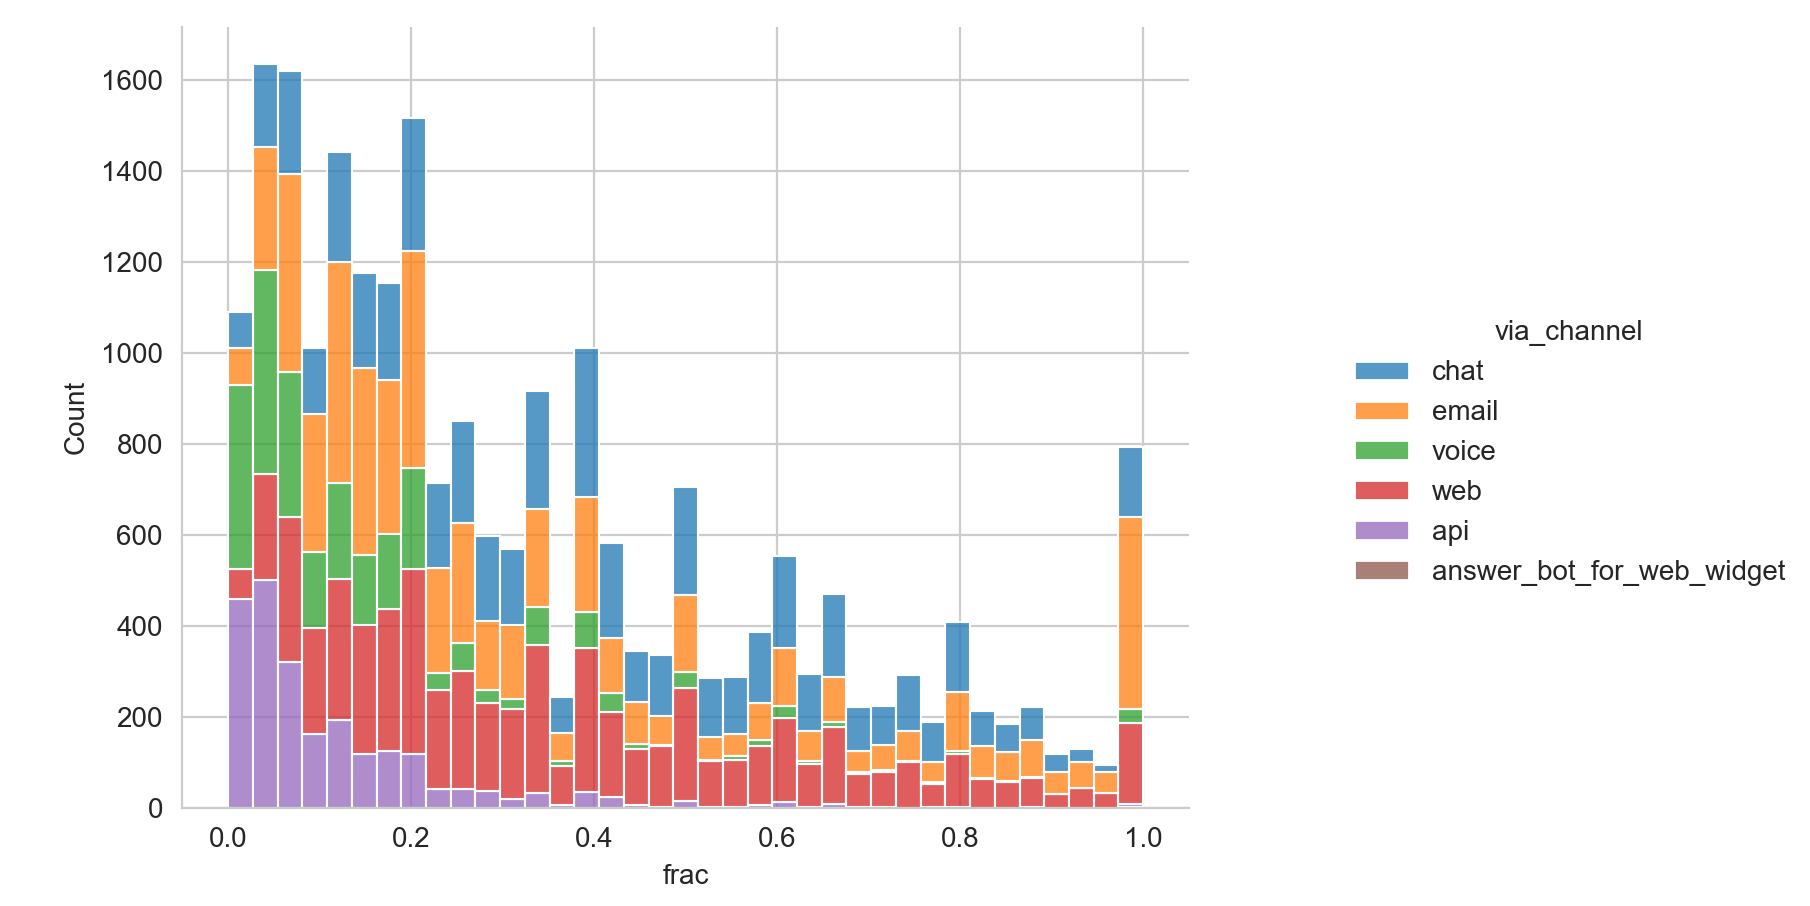

In [319]:
sns.displot(data=rdf, x='frac', hue='via_channel', 
            multiple='stack', #{“layer”, “dodge”, “stack”, “fill”}
#             cumulative=True, 
           )

//anaconda3/envs/sklearn/lib/python3.9/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


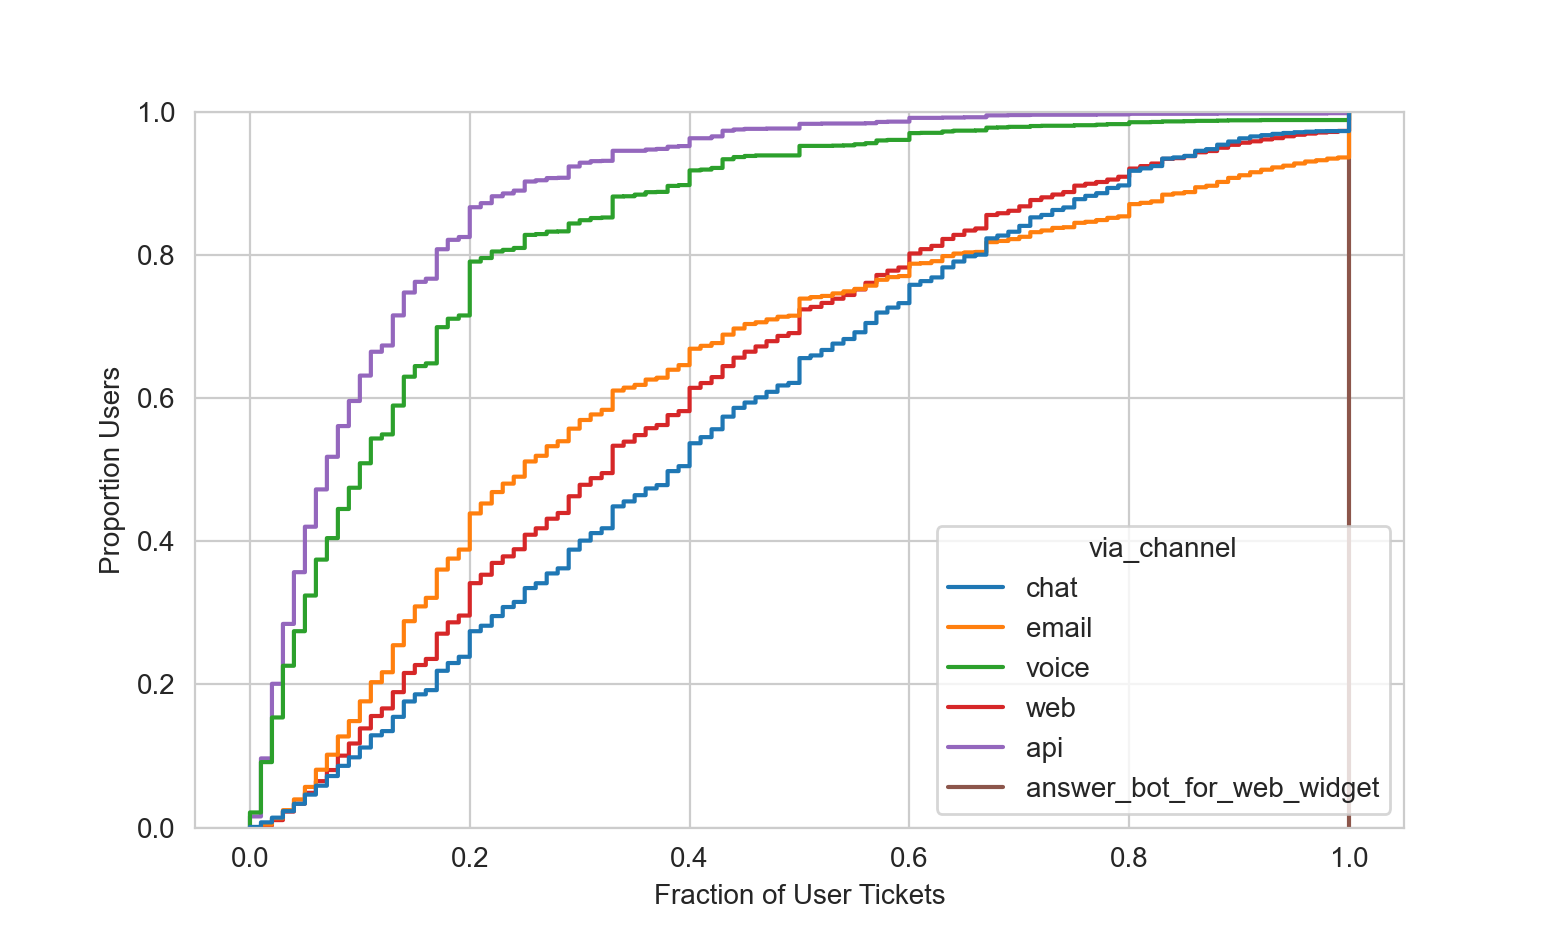

<AxesSubplot:xlabel='frac', ylabel='Proportion'>

Text(0, 0.5, 'Proportion Users')

Text(0.5, 0, 'Fraction of User Tickets')

In [325]:
_, ax = plt.subplots(figsize=(8,5))
sns.ecdfplot(data=rdf, x='frac', hue='via_channel', 
#             multiple='stack', #{“layer”, “dodge”, “stack”, “fill”}
#             cumulative=True, 
            ax=ax
           )
ax.set_ylabel('Proportion Users')
ax.set_xlabel('Fraction of User Tickets')